# Using Mapbox for background map tiles for a bus route

(Requires Mapbox API token)

(-0.5, 799.5, 179.5, -0.5)

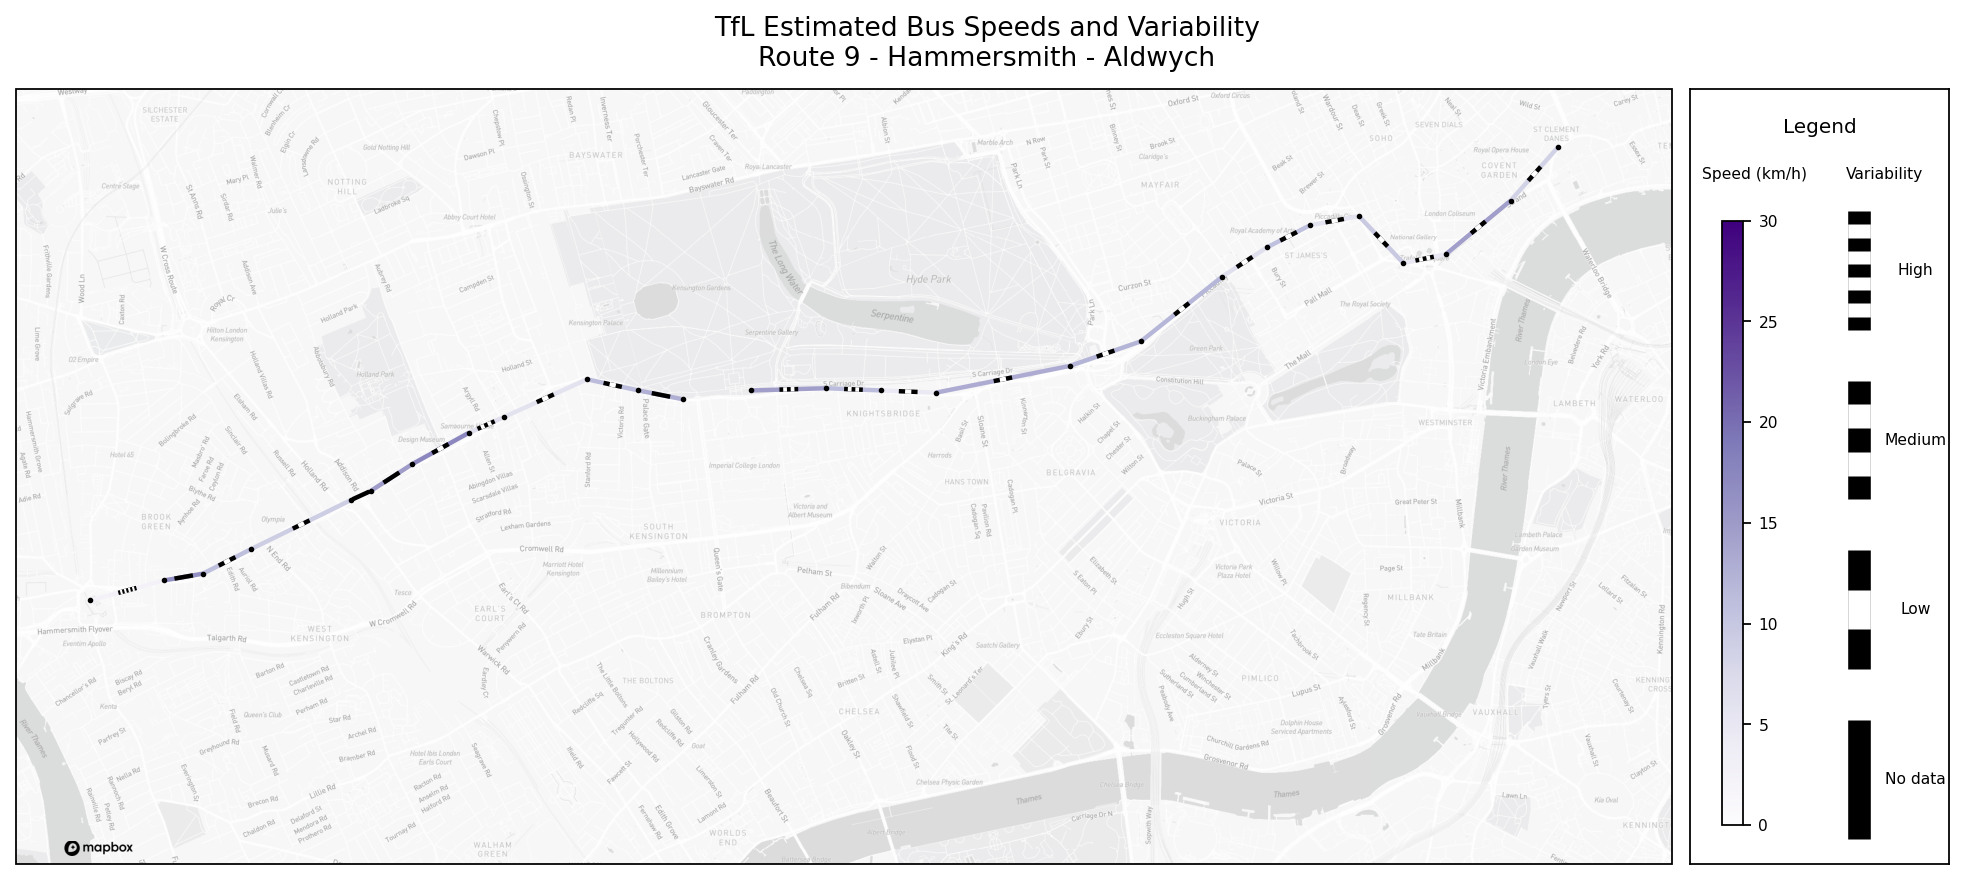

In [1]:
%load_ext dotenv
%dotenv

import pandas as pd
import numpy as np
import os
from vizent.vizent_plot import create_plot, add_lines
from scipy.stats import sem
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
import matplotlib.image as mpimg
import matplotlib.text as text
import warnings

# Filter warnings for gallery image only
warnings.filterwarnings('ignore')

edge_estimates = pd.read_csv('sample-data/bus-route-estimates.csv')
stops = pd.read_csv('sample-data/bus-route-stops.csv')

mapbox_light = cimgt.MapboxTiles(access_token=os.environ['MAPBOX_API_TOKEN'], 
                                 map_id='light-v11')

transformed = mapbox_light.crs.transform_points(src_crs=ccrs.PlateCarree(), 
                                                x=stops['lon'], y=stops['lat'])

stops['transformed_x'] = [i[0] for i in transformed]
stops['transformed_y'] = [i[1] for i in transformed]

edges = edge_estimates.merge(stops[['naptanId','transformed_x',
                                    'transformed_y']]\
                      .rename({'transformed_x': 'x_start', 
                               'transformed_y': 'y_start', 
                               'naptanId': 'start_naptanId'}, axis=1), 
                                how='inner', on='start_naptanId')

edges = edges.merge(stops[['naptanId','transformed_x','transformed_y']].rename(
                            {'transformed_x': 'x_end', 
                            'transformed_y': 'y_end', 
                            'naptanId': 'end_naptanId'
                            }, axis=1), how='inner', on='end_naptanId')

vizent_fig = create_plot(use_glyphs=False, 
                         use_lines=True, 
                         show_legend=True, 
                         show_axes=False, 
                         use_cartopy=True, 
                         cartopy_projection=mapbox_light.crs,
                         extent=[-0.2293, -0.1102, 51.4807, 51.5154], 
                         scale_x=12.7, 
                         scale_y=5.7)

vizent_fig[0].subplots_adjust(left=0.02, right=0.98, bottom = 0.05, top=0.9, 
                              wspace = 0.02)

vizent_fig[0].dpi = 160

vizent_fig[0].suptitle("TfL Estimated Bus Speeds and Variability\n\
Route 9 - Hammersmith - Aldwych")

vizent_fig[1].add_image(mapbox_light, 14, zorder=0)
vizent_fig[1].plot(stops['transformed_x'], stops['transformed_y'],
                   lw=0, marker='o', color='k', markersize=1.5)

viz_df = edges.groupby(['start_naptanId', 'end_naptanId', 
                        'distance', 'x_start', 'x_end', 
                        'y_start', 'y_end'])['estimate_seconds']\
                        .agg([np.mean, sem]).reset_index()

viz_df['kmh'] = 3.6 * (viz_df['distance'] / viz_df['mean'])

add_lines(vizent_fig,
          x_starts=viz_df['x_start'], 
          x_ends=viz_df['x_end'], 
          y_starts=viz_df['y_start'], 
          y_ends=viz_df['y_end'], 
          color_values=viz_df['kmh'],
          freq_values=viz_df['sem'], 
          width_values=[2 for l in range(viz_df.shape[0])], 
          colormap='Purples', 
          color_min=0,
          color_max=30,
          label_fontsize=7, 
          legend_title='Legend', 
          color_label='Speed (km/h)', 
          frequency_label='Variability', 
          length_type='units',
          style='set_length',
          striped_length=150,
          scale_dp=0,
          freq_n=3)

sem_scale = []
for child in vizent_fig[0].axes[0].get_children():
    if type(child)==text.Annotation:
        try:
            number = int(child.get_text())
            sem_scale.append(number)
        except:
            pass
for child in vizent_fig[0].axes[0].get_children():
    if type(child)==text.Annotation:
        try: 
            number = int(child.get_text())
            if number == min(sem_scale):
                child.set_text('Low')
            elif number == max(sem_scale):
                child.set_text('High')
            else:
                child.set_text('Medium')
        except:
            pass

# Add mapbox attribution
im = mpimg.imread('_static/mapbox-logo-black.png')
imax = vizent_fig[1].inset_axes([0.0, 0.01, 0.1, 0.02])
imax.imshow(im)
imax.axis('off')

© [Mapbox](https://www.mapbox.com/about/maps/) © [OpenStreetMap](http://www.openstreetmap.org/copyright) [Improve this map](https://www.mapbox.com/map-feedback/)

Powered by TfL Open Data. Contains OS data © Crown copyright and database rights 2016 and Geomni UK Map data © and database rights [2019]  